In [1]:
import cptac
import scipy
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statistics
import copy
import cptac.utils as ut
import matplotlib.patches as mpatches

In [2]:
luad = cptac.Luad()

In [3]:
def get_original_corr(tissue, gene):
    original_corr = 0
    df_real_corr = pd.read_csv("data/correlations_dataframe.csv")
    for index, value in enumerate(df_real_corr["Cancer_Type"]):
        if value == tissue:
            if (df_real_corr.loc[index]["Gene"] == gene and df_real_corr.loc[index]["Tissue_Type"] == "tumor"):
                original_corr = df_real_corr.loc[index]["Correlation"]
    return original_corr


In [4]:
def get_normal_vs_tumor_plot_and_delta_corr(tissue, gene):
    df_normal = tissue.multi_join({"proteomics": gene, "transcriptomics" : gene}, levels_to_drop=["Database_ID"], tissue_type= "normal")
    df_tumor = tissue.multi_join({"proteomics": gene, "transcriptomics" : gene},levels_to_drop=["Database_ID"], tissue_type="tumor")
    fig = sns.regplot(y = df_normal[gene+"_proteomics"], x = df_normal[gene+"_transcriptomics"], label= 'Normal')
    fig = sns.regplot(y = df_tumor[gene+"_proteomics"], x = df_tumor[gene+"_transcriptomics"],  label = 'Tumor')
    
    plt.legend(title = 'Tissue', bbox_to_anchor=(1.05, 1), loc='upper left')
    fig.set(xlabel='RNA Abundance', ylabel='Protein Abundance')
    plt.text(-0.1, 1.15, 'A', transform = fig.transAxes, 
             fontsize = 16, fontweight = 'bold', va = 'top', ha = 'right')
    plt.savefig('Figures/Figure S4a) Original Correlation Plot.png')
    plt.show()
    df_normal = df_normal.dropna()
    df_tumor = df_tumor.dropna()
    corr_normal,pval_normal = scipy.stats.pearsonr(df_normal[gene+"_proteomics"], df_normal[gene+"_transcriptomics"])
    corr_tumor, pval_tumor = scipy.stats.pearsonr(df_tumor[gene+"_proteomics"], df_tumor[gene+"_transcriptomics"])
    delta_corr =  corr_tumor - corr_normal
    return delta_corr

In [5]:
def create_dataframe_with_labels(tissue, gene, clinical_stage):
    df = tissue.multi_join({"proteomics": gene, "transcriptomics" : gene, "clinical" : clinical_stage}, levels_to_drop=["Database_ID"])
    for i, j in enumerate(df[clinical_stage]):
        if (type(j) == str):
            df[clinical_stage][i] = "Tumor"
        elif(math.isnan(j)):
            df[clinical_stage][i] = "Normal"
        else:
            df[clinical_stage][i] = "Tumor"

    df = df[list(df.columns[:3])]
    df = df.dropna()
    return df

In [6]:
def permutate (df,original_correlation, label_1, label_2, permutation_times, gene, clinical_stage, original_delta_corr):
    permutation_list = []
    permu_df = copy.deepcopy(df)
    plot_list = []
    count = 0
    for i in range(permutation_times):
        permu_df[clinical_stage] = np.random.permutation(permu_df[clinical_stage])
        permu_is_label_1 = permu_df[clinical_stage] == label_1
        permu_is_label_2 = permu_df[clinical_stage] == label_2
        label_1_correlation,label_1_pval = scipy.stats.pearsonr(permu_df[permu_is_label_1][gene+"_proteomics"], permu_df[permu_is_label_1][gene+"_transcriptomics"])
        label_2_correlation,label_2_pval = scipy.stats.pearsonr(permu_df[permu_is_label_2][gene+"_proteomics"], permu_df[permu_is_label_2][gene+"_transcriptomics"])
        delta = label_1_correlation - label_2_correlation
        permutation_list.append(delta)
        if (count < 4):
            plot_list.append([permu_df, permu_is_label_1, permu_is_label_2])
            count += 1
    z_score = (original_correlation - np.mean(permutation_list)) / np.std(permutation_list)
    p_val = scipy.stats.norm.sf(abs(z_score))*2
    return p_val, plot_list, permutation_list

In [7]:
def plot_permutation_histogram(permutation_list):
    fig = sns.distplot(permutation_list, color = 'grey')

    #plt.show()
    maxx = (max(fig.get_lines()[0].get_data()[1]))
    plt.vlines(original_delta_corr, 0, maxx, color = 'red')
    #fig= plt.plot([original_delta_corr, original_delta_corr], [0, maxx], color = "red")
    red_patch = mpatches.Patch(color='red', label='Original '  + r'$\Delta$' +  ' Correlation')
    grey_patch = mpatches.Patch(color='grey', label='Distribution of Permuted ' + r'$\Delta$' +  ' Correlations')
    plt.ylim([0,maxx+.7])
    plt.legend(handles=[red_patch,grey_patch], bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel(r'$\Delta$' + ' Correlation')
    plt.ylabel('Distribution')
    plt.text(-0.1, 1.15, 'C', transform = fig.transAxes, 
             fontsize = 16, fontweight = 'bold', va = 'top', ha = 'right')
    plt.savefig('Figures/Figure S4C) Permutation Histogram.png')
    plt.show()

In [8]:
def create_df_to_plot_2x5_permutations(list_of_permutated_df,gene):
    x_list = []
    y_list = []
    hue_list = []
    col_list = []
    for index, i in enumerate(list_of_permutated_df):
        tmp_df = i[0]
        tmp_vool = i[1]
        for i in tmp_vool:
            if (i == True):
                hue_list.append("Normal")
            else:
                hue_list.append("Tumor")
            col_list.append(str(index))
        for i in tmp_df[gene+"_proteomics"]:
            x_list.append(i)
        for i in tmp_df[gene+"_transcriptomics"]:
            y_list.append(i)
    plot_df = pd.DataFrame({"Protein Abundance" : x_list, "RNA Abundance" : y_list, "Tissue" : hue_list, "Permutation Number" : col_list})
    return plot_df

In [9]:
def create_2x5_plot(plot_df):
    global first
    first = True
    def annotate(data, **kws):
        global first
        if first == True:
            ax = plt.gca()
            ax.text(-0.1, 1.15, 'B', transform = ax.transAxes, 
                 fontsize = 16, fontweight = 'bold', va = 'top', ha = 'right')
        first = False
    fig = sns.FacetGrid(data = plot_df, col = 'Permutation Number', col_wrap=2, hue = 'Tissue', legend_out = True)
    fig.map_dataframe(annotate)
    fig.map_dataframe(sns.regplot, x = 'RNA Abundance', y = 'Protein Abundance')
    fig.add_legend()
    fig.set_axis_labels('RNA Aundance', 'Protein Abundance')
    plt.savefig('Figures/Figure S4B) Permuted Correlation Plots.png')
    plt.show()


# Permutation Plots Notebook

Notebook to create 3 plots for a single gene in a single tissue. Plots a scatterplot of normal and tumor, plots 10 scatterplots in a single 2x5 image of permutated data, and a distribution plot showing all delta correlations vs the original delta correlation

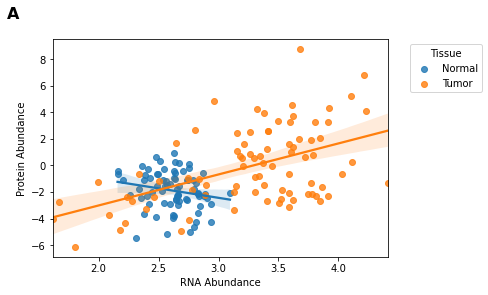

<ipython-input-5-b80a9c548aaa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[clinical_stage][i] = "Tumor"
<ipython-input-5-b80a9c548aaa>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[clinical_stage][i] = "Normal"


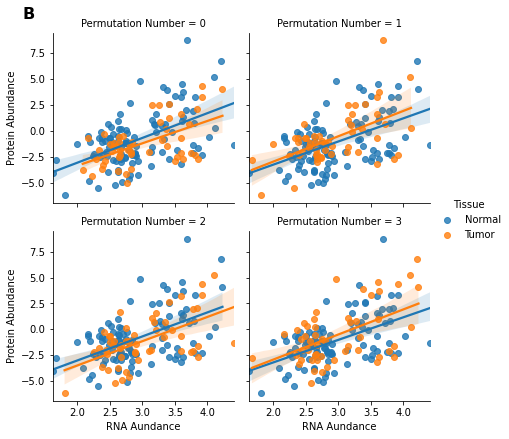

C:\Users\nanel\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


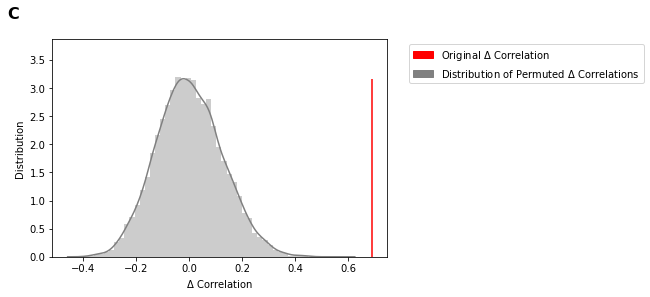

In [10]:
original_corr = get_original_corr("LUAD", "TP53")

original_delta_corr = get_normal_vs_tumor_plot_and_delta_corr(luad,"TP53")

df_with_labels = create_dataframe_with_labels(luad, "TP53", "Stage")

pvaltest, list_of_permutated_df, permutation_list = permutate(df_with_labels, original_corr, "Tumor", "Normal", 10000, "TP53", "Stage", original_delta_corr)

plot_df = create_df_to_plot_2x5_permutations(list_of_permutated_df, "TP53")

create_2x5_plot(plot_df)

plot_permutation_histogram(permutation_list)

